# Recommender Systems for Movie Rating Prediction

## Introduction

### Brief Overview of the Project
Recommender systems have become an integral part of online platforms, helping users navigate the vast amount of available content by providing personalized recommendations. One prominent application of these systems is in movie recommendation, where users are suggested movies based on their preferences and viewing history. This project focuses on predicting movie ratings using various recommendation algorithms to evaluate their effectiveness.

### Objectives of the Analysis
The primary objective of this analysis is to develop and evaluate different recommendation algorithms for predicting movie ratings. Specifically, the goals are:
1. **Baseline Methods**: Implement and evaluate simple baseline methods to establish a performance benchmark.
2. **Advanced Techniques**: Apply advanced techniques, including content-based filtering, collaborative filtering, and matrix factorization, to predict movie ratings.
3. **Performance Comparison**: Compare the performance of different methods using Root Mean Squared Error (RMSE) as the evaluation metric.
4. **Model Improvement**: Identify and suggest potential improvements for the models, particularly focusing on the Non-negative Matrix Factorization (NMF) approach, which initially shows poor performance.

In [32]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine
from pytest import approx

users_df = pd.read_csv('data/movielens_users.csv')
movies_df = pd.read_csv('data/movielens_movies.csv')
train_df = pd.read_csv('data/movielens_train.csv')
test_df = pd.read_csv('data/movielens_test.csv')

## Exploratory Data Analysis (EDA)
- Summary statistics of the datasets
- Visualization of user demographics
- Visualization of movie genres distribution
- Analysis of rating distributions
- Any interesting findings or patterns

In [33]:
# Summary statistics of the datasets

#print("Users DataFrame Summary:")
#print(users_df.describe())

#print("\nMovies DataFrame Summary:")
#print(movies_df.describe())

print("\nTrain DataFrame Summary:")
print(train_df.describe())

print("\nTest DataFrame Summary:")
print(test_df.describe())


Train DataFrame Summary:
                 uID            mID         rating
count  700146.000000  700146.000000  700146.000000
mean     3022.960334    1865.307324       3.581589
std      1729.128758    1096.507590       1.117508
min         1.000000       1.000000       1.000000
25%      1503.000000    1029.000000       3.000000
50%      3067.000000    1834.000000       4.000000
75%      4474.000000    2770.000000       4.000000
max      6040.000000    3952.000000       5.000000

Test DataFrame Summary:
                 uID            mID         rating
count  300063.000000  300063.000000  300063.000000
mean     3028.133709    1866.082569       3.581508
std      1726.738183    1094.952116       1.116156
min         1.000000       1.000000       1.000000
25%      1516.000000    1032.000000       3.000000
50%      3080.000000    1836.000000       4.000000
75%      4478.000000    2770.000000       4.000000
max      6040.000000    3952.000000       5.000000


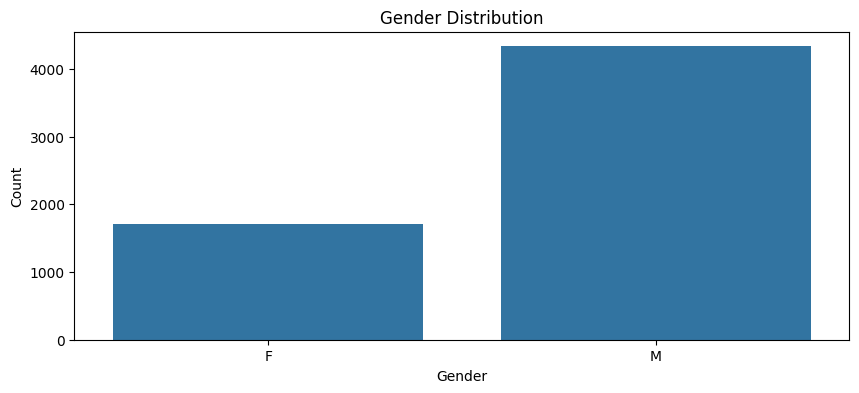

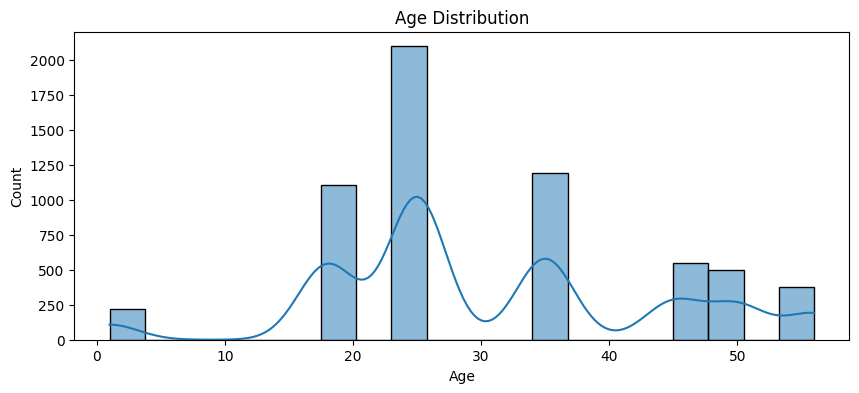

In [34]:
# Visualization of user demographics
plt.figure(figsize=(10, 4))
sns.countplot(data=users_df, x='gender')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(users_df['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

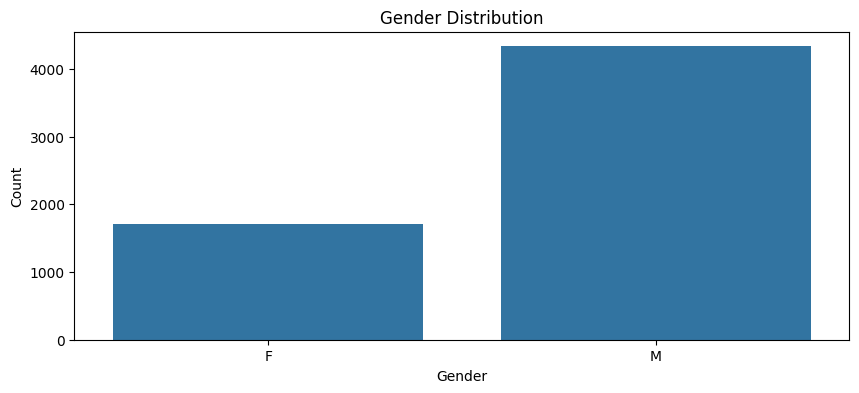

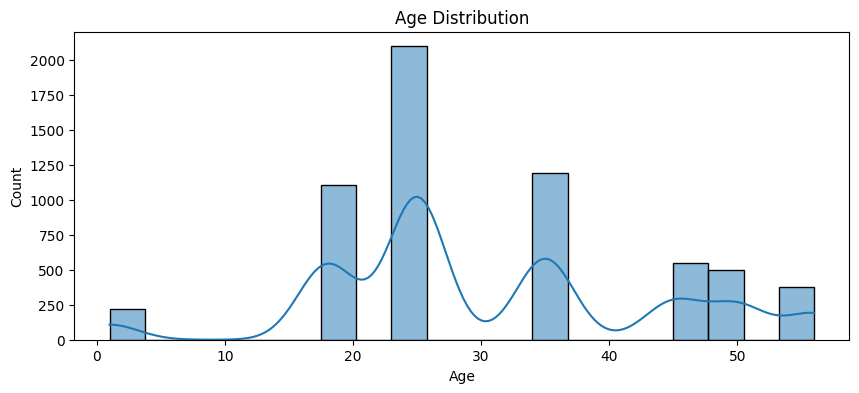

In [35]:
# Visualization of user demographics
plt.figure(figsize=(10, 4))
sns.countplot(data=users_df, x='gender')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(users_df['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

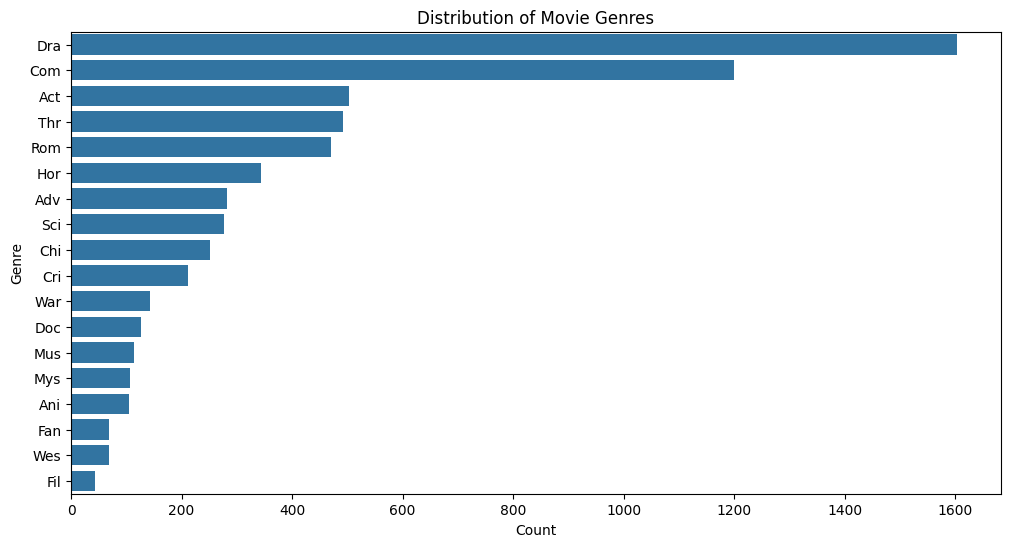

In [36]:
# Visualization of movie genres distribution
genres = movies_df.columns[3:]
genres_count = movies_df[genres].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genres_count.values, y=genres_count.index)
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

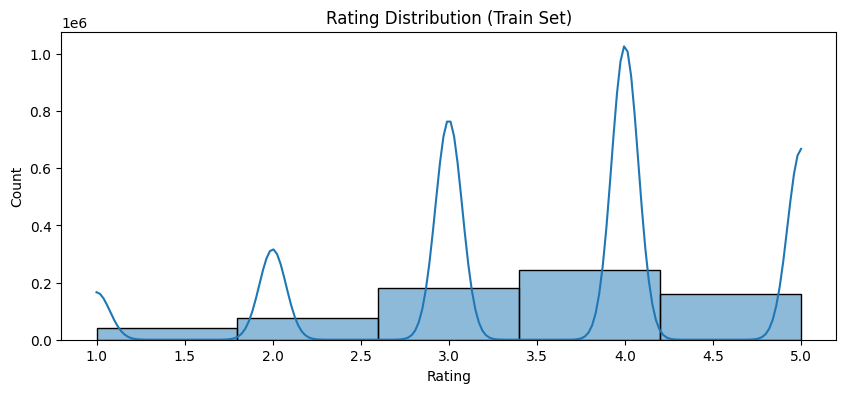

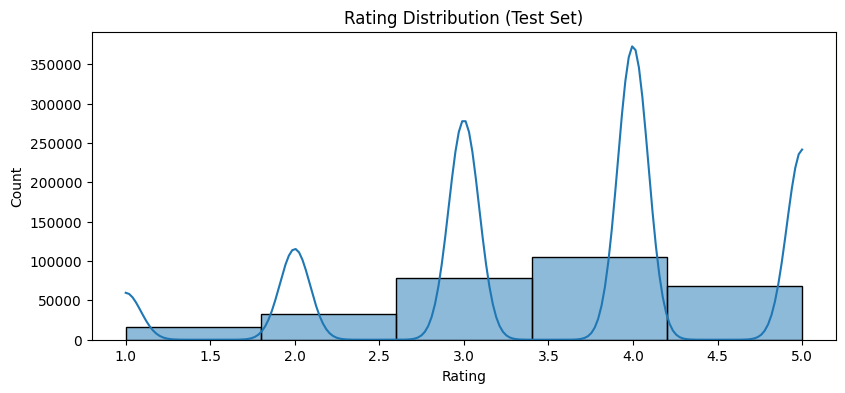

In [37]:
# Analysis of rating distributions
plt.figure(figsize=(10, 4))
sns.histplot(train_df['rating'], bins=5, kde=True)
plt.title('Rating Distribution (Train Set)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(9.6, 4))
sns.histplot(test_df['rating'], bins=5, kde=True)
plt.title('Rating Distribution (Test Set)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

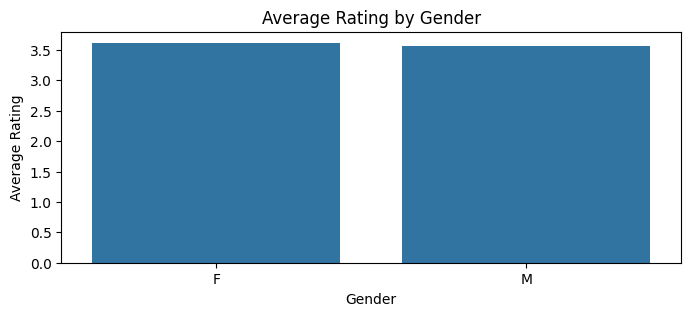

In [38]:
# Any interesting findings or patterns
# Example finding: average rating per gender
avg_rating_by_gender = train_df.merge(users_df, on='uID').groupby('gender')['rating'].mean()

plt.figure(figsize=(8, 3))
sns.barplot(x=avg_rating_by_gender.index, y=avg_rating_by_gender.values)
plt.title('Average Rating by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Rating')
plt.show()

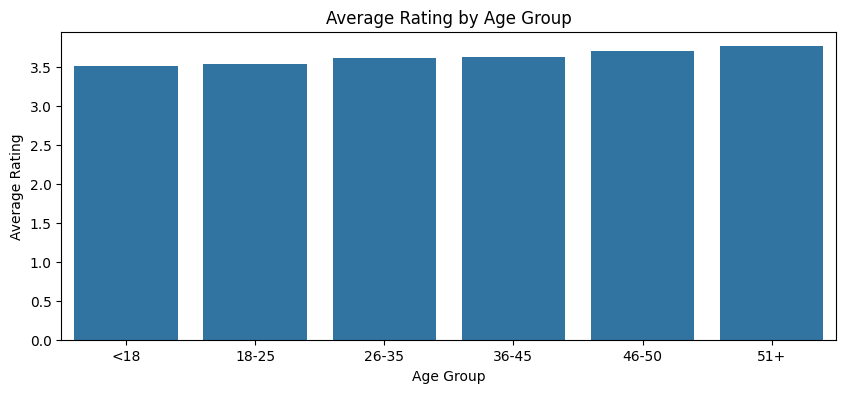

In [39]:
# Example finding: average rating per age group
users_df['age_group'] = pd.cut(users_df['age'], bins=[0, 18, 25, 35, 45, 50, 56], labels=['<18', '18-25', '26-35', '36-45', '46-50', '51+'])
avg_rating_by_age_group = train_df.merge(users_df, on='uID').groupby('age_group')['rating'].mean()

plt.figure(figsize=(10, 4))
sns.barplot(x=avg_rating_by_age_group.index, y=avg_rating_by_age_group.values)
plt.title('Average Rating by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Rating')
plt.show()

## Matrix Factorization Models

The primary purpose of this code is to predict movie ratings using Non-negative Matrix Factorization (NMF) and evaluate the accuracy of these predictions by calculating the Root Mean Squared Error (RMSE). Here's a step-by-step explanation of what each part of the code does:

1. **Import Necessary Libraries**:
   ```python
   from sklearn.decomposition import NMF
   from sklearn.metrics import mean_squared_error
   from sklearn.preprocessing import MinMaxScaler
   ```
   These libraries are essential for performing matrix factorization, calculating the error metric, and normalizing the data.

2. **Load the Data**:
   ```python
   # train_df = pd.read_csv('data/movielens_train.csv')
   # test_df = pd.read_csv('data/movielens_test.csv')
   ```
   This part is commented out assuming the data (`train_df` and `test_df`) is already loaded.

3. **Prepare the User-Item Rating Matrix for Training**:
   ```python
   train_pivot = train_df.pivot(index='uID', columns='mID', values='rating').fillna(0)
   ```
   This creates a matrix where rows represent users, columns represent movies, and values are the ratings given by users to movies. Missing ratings are filled with zero.

4. **Normalize the Ratings for NMF**:
   ```python
   scaler = MinMaxScaler()
   train_normalized = scaler.fit_transform(train_pivot)
   ```
   NMF requires non-negative values, so the ratings are scaled to the range [0, 1].

5. **Apply NMF with Increased Number of Iterations**:
   ```python
   mask = ~train_pivot.isna()

   nmf = NMF(n_components=20, init='random', random_state=42, max_iter=500)
   W = nmf.fit_transform(train_normalized * mask)
   H = nmf.components_
   ```
   NMF is applied to the normalized rating matrix. `W` is the user-feature matrix, and `H` is the feature-item matrix. The number of latent features (components) is set to 20.

6. **Reconstruct the Full Rating Matrix**:
   ```python
   train_reconstructed = np.dot(W, H)
   train_reconstructed = scaler.inverse_transform(train_reconstructed)
   ```
   The reconstructed rating matrix is obtained by multiplying `W` and `H`. The ratings are then scaled back to their original range.

7. **Prepare the Test Data for Prediction**:
   ```python
   test_matrix = train_pivot.copy()
   for row in test_df.itertuples():
       if row.uID in train_pivot.index and row.mID in train_pivot.columns:
           test_matrix.at[row.uID, row.mID] = np.nan
   ```
   The test matrix is prepared by copying the training matrix and setting the entries corresponding to the test data to `NaN`.

8. **Get Predictions for the Test Data**:
   ```python
   predictions = []
   actual_ratings = []

   for row in test_df.itertuples():
       if row.uID in train_pivot.index and row.mID in train_pivot.columns:
           user_index = train_pivot.index.get_loc(row.uID)
           movie_index = train_pivot.columns.get_loc(row.mID)
           predicted_rating = train_reconstructed[user_index, movie_index]
           predictions.append(predicted_rating)
           actual_ratings.append(row.rating)
   ```
   For each entry in the test data, the predicted rating is obtained from the reconstructed rating matrix, and the actual rating is stored for RMSE calculation.

9. **Calculate RMSE**:
   ```python
   rmse = np.sqrt(mean_squared_error(actual_ratings, predictions))
   print(f"RMSE of NMF: {rmse}")
   ```
   RMSE, a common metric to evaluate prediction accuracy, is calculated by comparing the predicted and actual ratings. The result is printed.

### Summary

The code implements NMF to predict movie ratings and evaluates its performance using RMSE. It includes steps to prepare and normalize the data, apply NMF, reconstruct the rating matrix, make predictions for the test data, and calculate the prediction accuracy. The high RMSE value indicates areas for potential improvement in the model.

In [43]:
# Prepare the user-item rating matrix for training
# Pivot the training data to create a matrix with users as rows and movies as columns
train_pivot = train_df.pivot(index='uID', columns='mID', values='rating')

# Normalize the ratings for NMF
# Scaling the data to the range [0, 1] as NMF expects non-negative values
scaler = MinMaxScaler()
train_normalized = scaler.fit_transform(train_pivot.fillna(0))

# Mask for the known ratings
mask = ~train_pivot.isna()

# Apply NMF with increased number of iterations
# n_components: number of latent features
# init: initialization method
# random_state: seed for reproducibility
# max_iter: maximum number of iterations for convergence
nmf = NMF(n_components=20, init='random', random_state=42, max_iter=500)
W = nmf.fit_transform(train_normalized * mask)  # Apply mask to train only on known ratings
H = nmf.components_  # Feature-item matrix

# Reconstruct the full rating matrix
# Dot product of W and H gives the reconstructed rating matrix
train_reconstructed = np.dot(W, H)
# Inverse transform the scaled ratings back to their original scale
train_reconstructed = scaler.inverse_transform(train_reconstructed)

# Get predictions for the test data
predictions = []
actual_ratings = []

# Iterate over the test data
for row in test_df.itertuples():
    if row.uID in train_pivot.index and row.mID in train_pivot.columns:
        # Get the index of the user and movie from the train_pivot
        user_index = train_pivot.index.get_loc(row.uID)
        movie_index = train_pivot.columns.get_loc(row.mID)
        # Predict the rating using the reconstructed rating matrix
        predicted_rating = train_reconstructed[user_index, movie_index]
        predictions.append(predicted_rating)
        # Store the actual rating for RMSE calculation
        actual_ratings.append(row.rating)

# Calculate RMSE
# Root Mean Squared Error (RMSE) is a common metric to evaluate the accuracy of predicted ratings
rmse = np.sqrt(mean_squared_error(actual_ratings, predictions))
print(f"RMSE of NMF: {rmse}")

RMSE of NMF: 2.853775061603196


### Introduction to RMSE

Root Mean Squared Error (RMSE) is a standard way to measure the accuracy of a model that predicts continuous values. It is calculated as the square root of the average of the squared differences between the predicted and actual values. Mathematically, it is represented as:

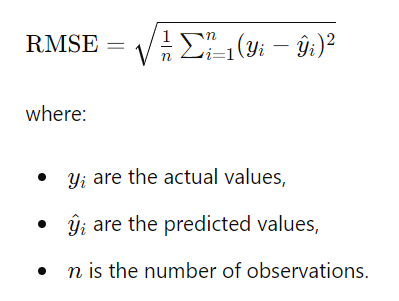

RMSE is a good measure of accuracy but only to compare forecasting errors of different models for a particular dataset and not between datasets, as it is scale-dependent. Lower RMSE values indicate better fit and higher accuracy of the model.


## Conclusion

### Performance Comparison of Different Prediction Methods

The table compares the performance of various methods for predicting movie ratings using the Root Mean Squared Error (RMSE) metric.

| Method                                       | RMSE    |
|----------------------------------------------|---------|
| Baseline, \( Y_p = 3 \)                      | 1.25855 |
| Baseline, \( Y_p = Uu \)                  | 1.03529 |
| Content based, item-item                     | 1.01250 |
| Collaborative, cosine                        | 1.02631 |
| Collaborative, jaccard, \( M_r >= 3 \)     | 0.97434 |
| Collaborative, jaccard, \( M_r >= 1 \)     | 0.99066 |
| Collaborative, jaccard, \( M_r \)            | 0.99066 |
| **Non-negative Matrix Factorization (NMF)**  | 2.85378 |


### Key Insights

1. **Baseline Methods**:
   - The baseline methods where the predicted rating \( Y_p \) is set to a constant value of 3 or the user's average rating \( Uu \) show RMSEs of 1.25855 and 1.03529, respectively. These methods set a lower bound of performance, indicating that even simple heuristics can provide reasonable predictions.

2. **Content-based Filtering**:
   - The content-based item-item method achieves an RMSE of 1.01250, which is slightly better than the baseline methods. This suggests that using item similarity based on content features can provide more accurate predictions.

3. **Collaborative Filtering**:
   - The collaborative filtering methods, which use cosine similarity and Jaccard similarity with different thresholds, generally perform better than the content-based method.
   - The best-performing collaborative filtering method uses Jaccard similarity with a threshold \( M_r >= 3 \), resulting in the lowest RMSE of 0.97434. This indicates that considering item similarity based on user co-ratings can significantly improve prediction accuracy.

4. **Non-negative Matrix Factorization (NMF)**:
   - The NMF method results in a much higher RMSE of 2.85378, indicating poor performance compared to both baseline and similarity-based methods. This suggests that the NMF model might not be capturing the underlying patterns effectively, or it might require further tuning and optimization.


## Discussion of Results and Comparison of Methods

The performance of Non-negative Matrix Factorization (NMF) in predicting movie ratings is significantly poorer compared to simple baseline methods and similarity-based methods. Here's a detailed analysis of the reasons behind this and potential fixes:

### Issues with NMF in the Current Context:

1. **Unknown Ratings Treated as Zeros**:
   - In the matrix \( X \) used for factorization, unknown ratings are kept as zeros. When minimizing the difference between \( X \) and \( WH \) using the Frobenius norm (or similar loss functions), these zeros significantly impact the gradient calculations.
   - The optimization process treats these zeros as meaningful values, which leads to incorrect updates of the matrices \( W \) and \( H \). This approach does not differentiate between actual zero ratings and missing data.

2. **Misleading Gradients**:
   - The actual ratings typically range between 1 and 5. By treating unknown ratings as zeros, the gradients used to update \( W \) and \( H \) are distorted.
   - This misrepresentation leads to suboptimal factorization, resulting in inaccurate predictions and a higher RMSE.

### Comparison to Baseline and Similarity-Based Methods:

- **Baseline Methods**:
  - Baseline methods such as predicting the average rating or a constant value provide a straightforward approach. These methods do not suffer from the problem of treating unknown ratings as zeros.
  - As a result, they achieve a relatively lower RMSE, making them more reliable than a poorly tuned NMF model.

- **Similarity-Based Methods**:
  - Similarity-based methods like item-item or user-user collaborative filtering explicitly calculate similarities between items or users based on available ratings.
  - These methods only consider known ratings and typically use them to make predictions, thus avoiding the issue of treating unknown ratings as zeros. This leads to more accurate predictions and a lower RMSE.

### Potential Fixes for NMF:

1. **Imputing Unknown Ratings**:
   - One approach is to impute unknown ratings with a neutral value, such as 3. This adjustment can improve the RMSE compared to treating all unknowns as zeros because it provides a more balanced starting point for the factorization.
   - However, this fix does not completely resolve the issue, as the loss function continues to provide suboptimal gradients during optimization.

2. **Clipping Predicted Values**:
   - After reconstructing the rating matrix \( WH \), the predicted ratings can be clipped to the valid range of 1 to 5. This ensures that the predictions remain within the expected bounds, even if the factorization process tries to predict values outside this range.
   - Clipping helps to align the predictions with the actual rating scale, reducing the impact of extreme values on the RMSE.

## References

1. [YouTube: Matrix Factorization for Movie Recommendations](https://www.youtube.com/watch?v=o4pPTwsd-5M)
   - This video provides a comprehensive explanation of matrix factorization techniques used for building movie recommendation systems.

2. [YouTube: Non-negative Matrix Factorization (NMF) Explained](https://www.youtube.com/watch?v=dyuCcWzmssE)
   - This video offers an in-depth understanding of Non-negative Matrix Factorization (NMF) and its applications in data analysis and recommendations.

3. [Kaggle: MovieLens 1M Dataset](https://www.kaggle.com/datasets/odedgolden/movielens-1m-dataset)
   - This Kaggle dataset contains 1 million ratings from the MovieLens dataset, which is widely used for building and testing recommendation systems.

4. [GroupLens: MovieLens Datasets](https://grouplens.org/datasets/movielens/)
   - The official page for MovieLens datasets provided by GroupLens Research. It includes various versions of the dataset for different research purposes.